# Análise de agrupamento no Python usando *scipy* e *scikitlearn*

In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import altair as alt # pacote para outros tipos de gráficos

# ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# AA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

from google.colab import drive, files
import os
import matplotlib.cm as cm

pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais
np.set_printoptions(precision=2, suppress=True)      # numpy: para todos os números aparecerem com duas casas decimais

In [99]:
# biplot com nomes nas observações
def biplot_names(score,coeff,labels=None,x=15,y=10,eixo_x='CP1',eixo_y='CP2'):
    fig, ax = plt.subplots(figsize=(x,y))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs * scalex
    yy = ys * scaley
    plt.scatter(xx, yy, s=2, linewidths=6)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, "Var"+str(i+1), color='green', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, labels[i], color='g', ha='center', va='center')
    for i, txt in enumerate(resultado.index):
      ax.annotate(txt, (xx[i], yy[i]), color='gray', fontsize=8)

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    plt.grid()
    plt.show()

In [100]:
# função para padronizar os valores das variáveis originais
def scale_sizes(sizes, min_size=1, max_size=2000):
    return ((sizes - np.min(sizes)) / (np.max(sizes) - np.min(sizes))) * (max_size - min_size) + min_size

In [101]:
# função para gerar diagramas de dispersão com bolhas de forma automática
def bubbles(df, pc, x=15, y=10):
  from random import randint
  colors = []
  for i in range(len(df.columns)):    # lista automática de cores
    colors.append('#%06X' % randint(0, 0xFFFFFF))
  for var, cor in zip(df.columns, colors):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y)
    xs = pc.iloc[:,0]
    ys = pc.iloc[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs*scalex
    yy = ys*scaley
    scaled_sizes = scale_sizes(df[var])
    ax.scatter(xx, yy, s=scaled_sizes, linewidths=2, color=cor)
    plt.xlabel('CP1', fontsize=12)
    plt.ylabel('CP2', fontsize=12)
    plt.title(var, fontsize=12)
    for i, txt in enumerate(pc.index):
        ax.annotate(txt, (xx.iloc[i], yy.iloc[i]), fontsize=9)
    plt.hlines(0, xx.min(), xx.max(), color='gray')
    plt.vlines(0, yy.min(), yy.max(), color='gray');

# Dados de poluição do ar

* SO2: teor de SO2 do ar em microgramas por metro cúbico;
* temp: temperatura média anual em graus Fahrenheit;
* manu: número de empresas industriais que empregam 20 ou mais trabalhadores;
* popul: tamanho da população (censo de 1970) em milhares;
* wind: velocidade média anual do vento em milhas por hora;
* precip: precipitação média anual em polegadas;
* predays: número médio de dias com precipitação por ano.

Leitura do conjunto de dados pelo google drive:

altere o endereço do arquivo ou faça o upload de outra forma


In [102]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/01-disciplinas/03-multivariada/05-dados')
# dados = pd.read_csv('air.csv', index_col='city')

In [103]:
# ou pelo link
dados = pd.read_csv('https://patriciasiqueira.github.io/arquivos/air.csv', index_col='city')

In [104]:
dados.shape

(41, 7)

In [105]:
dados.head(10)

,SO2,temp,manu,popul,wind,precip,predays
city,,,,,,,
Albany,46,47.60,44,116,8.80,33.36,135
Albuquerque,11,56.80,46,244,8.90,7.77,58
Atlanta,24,61.50,368,497,9.10,48.34,115
Baltimore,47,55.00,625,905,9.60,41.31,111
Buffalo,11,47.10,391,463,12.40,36.11,166
Charleston,31,55.20,35,71,6.50,40.75,148
Chicago,110,50.60,3344,3369,10.40,34.44,122
Cincinnati,23,54.00,462,453,7.10,39.04,132
Cleveland,65,49.70,1007,751,10.90,34.99,155


In [106]:
# fazendo cópia dos dados
X = dados.copy()
X.index = dados.index

### ACP usando a matriz de correlações - para possibilitar a construção de gráficos

In [107]:
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R
# armazenar resultados dos componentes principais para gerar o diagrama de dispersão dos grupos
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [108]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.49, -0.32,  0.54,  0.49,  0.25,  0.  ,  0.26],
       [ 0.08, -0.09, -0.23, -0.28,  0.06,  0.63,  0.68],
       [ 0.01,  0.68,  0.27,  0.34, -0.31,  0.49, -0.11],
       [-0.4 ,  0.19,  0.03,  0.11,  0.86,  0.18, -0.11],
       [ 0.73,  0.16, -0.16, -0.35,  0.27,  0.16, -0.44],
       [ 0.18,  0.61, -0.04, -0.09,  0.15, -0.55,  0.5 ],
       [-0.15,  0.02,  0.75, -0.65, -0.02,  0.01, -0.01]])

In [109]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([2.8 , 1.55, 1.43, 0.91, 0.36, 0.1 , 0.03])

In [110]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.97, 60.57, 80.5 , 93.24, 98.19, 99.62, 99.98])

In [111]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.49 -0.32  0.54  0.49  0.25  0.    0.26]
 [ 0.08 -0.09 -0.23 -0.28  0.06  0.63  0.68]
 [ 0.01  0.68  0.27  0.34 -0.31  0.49 -0.11]]


Biplot:

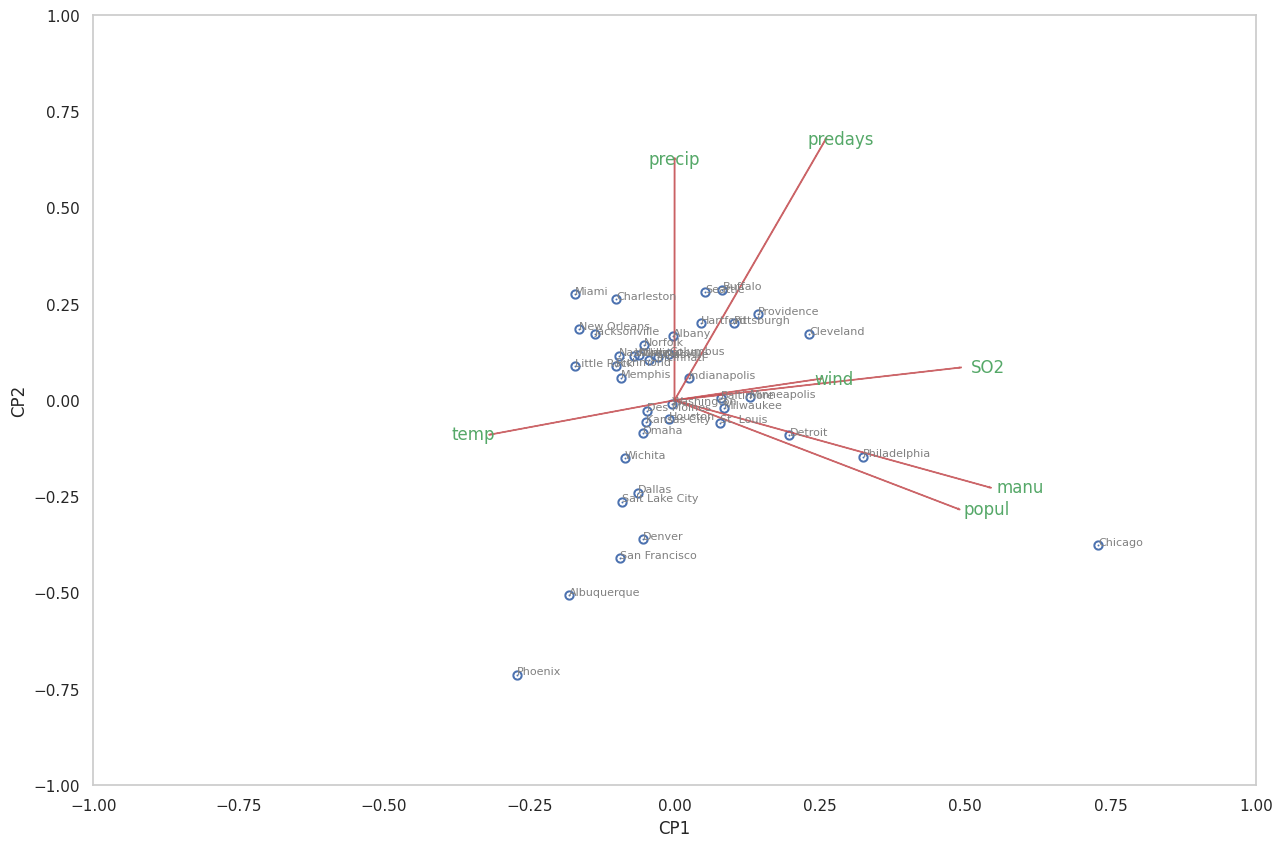

In [112]:
biplot_names(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))

### Análise de agrupamento hierárquico

Vizinho mais próximo:

In [113]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [114]:
Z = linkage(X, method='single')
# method='single' (vizinho + próximo), 'complete' (vizinho + distante), 'average' (distância média), 'weighted '(also called WPGMA)
# 'centroid', 'median', 'ward'

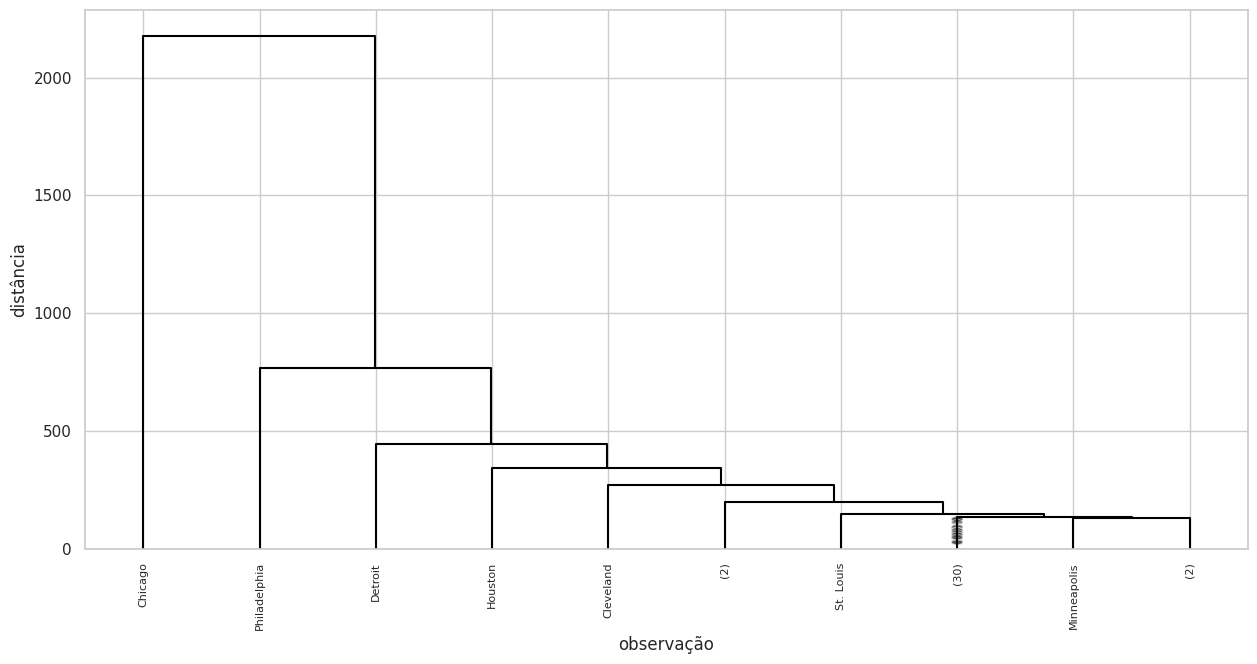

In [115]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Vizinho mais distante:

In [116]:
# definir a distância de corte para todos os dendrogramas
max_d = 1000

In [117]:
Z = linkage(X, method='complete')

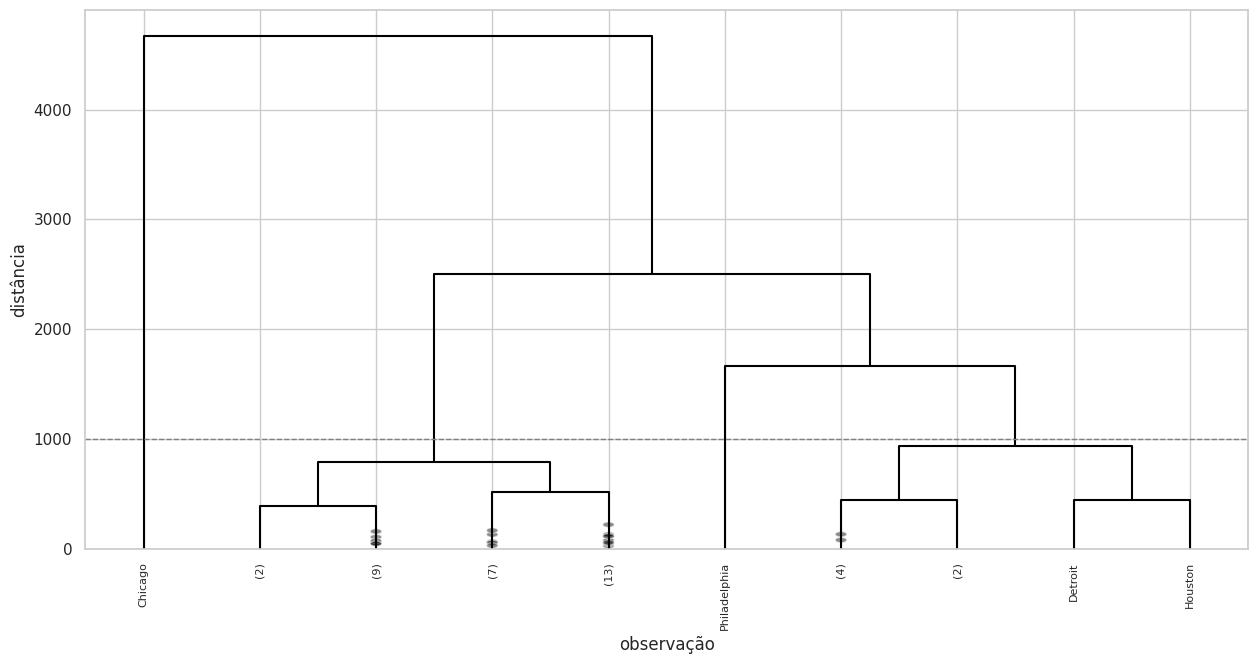

In [118]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Distância média:

In [119]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [120]:
Z = linkage(X, method='average')
# 'single', 'complete', 'average', 'centroid', 'ward'

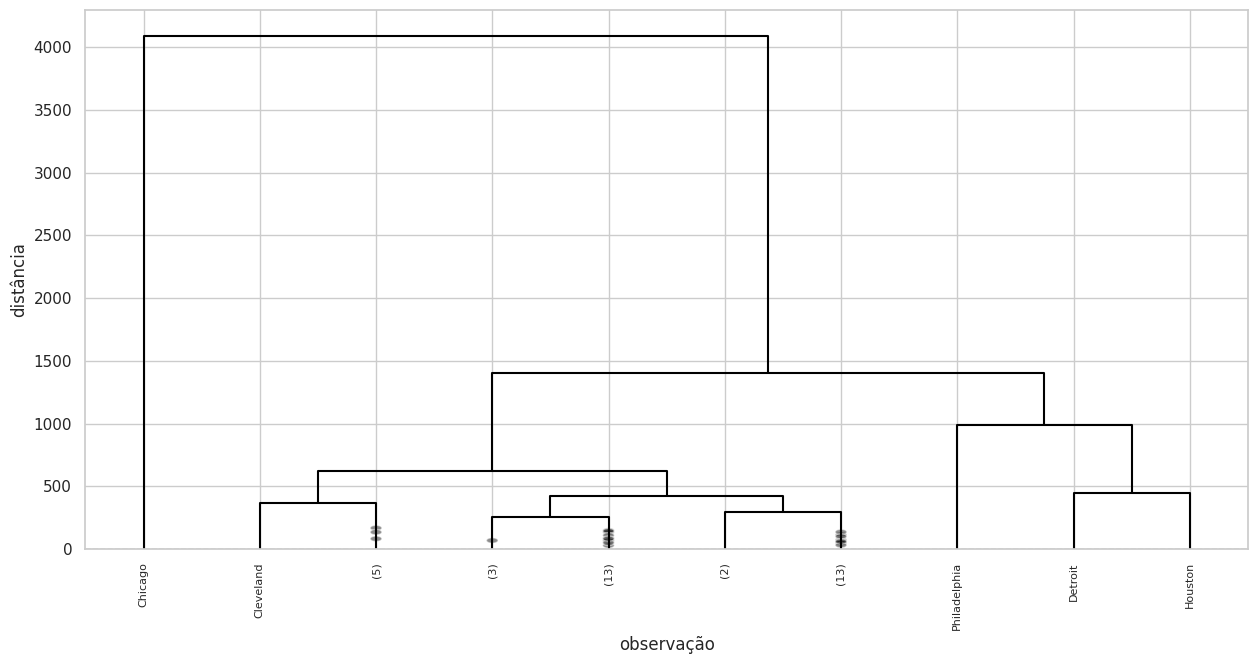

In [121]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Centroide:

In [122]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [123]:
Z = linkage(X, method='centroid')

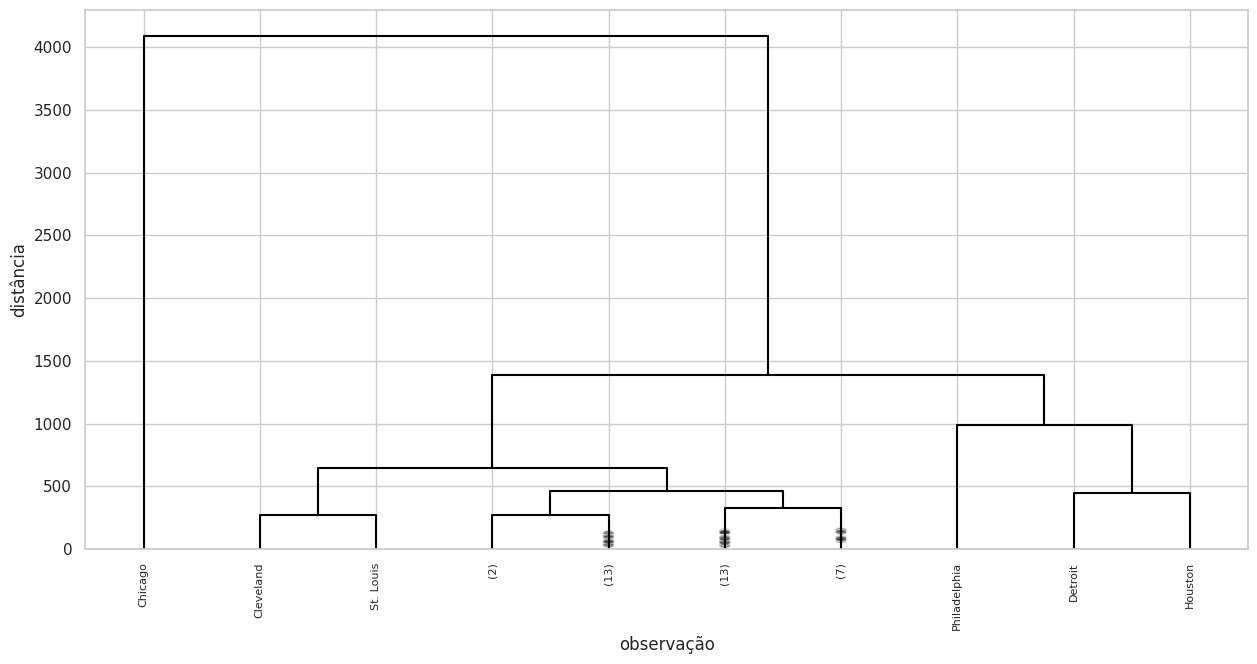

In [124]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Ward:

In [125]:
# definir a distância de corte para todos os dendrogramas
max_d = 2000

In [126]:
Z = linkage(X, method='ward')
# 'single', 'complete', 'average', 'centroid', 'ward'

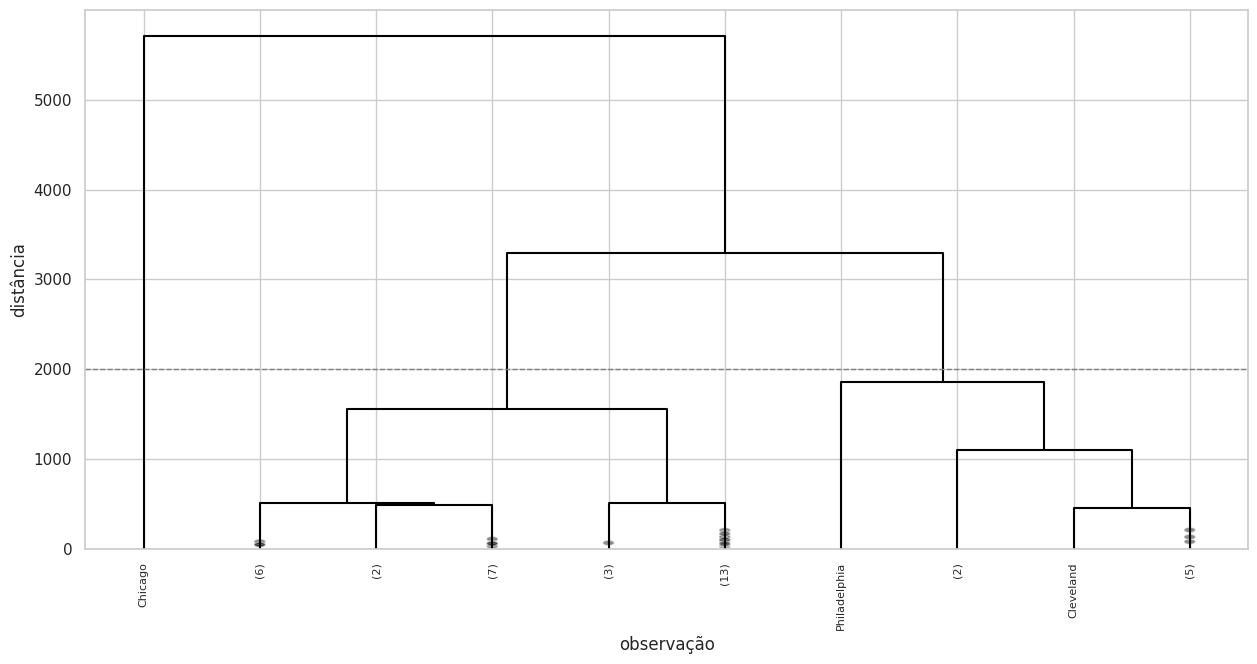

In [127]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Weighted (não vimos na teoria):

In [128]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [129]:
Z = linkage(X, method='weighted')
# method='single' (vizinho + próximo), 'complete' (vizinho + distante), 'average' (distância média), 'weighted '(also called WPGMA)
# 'centroid', 'median', 'ward'

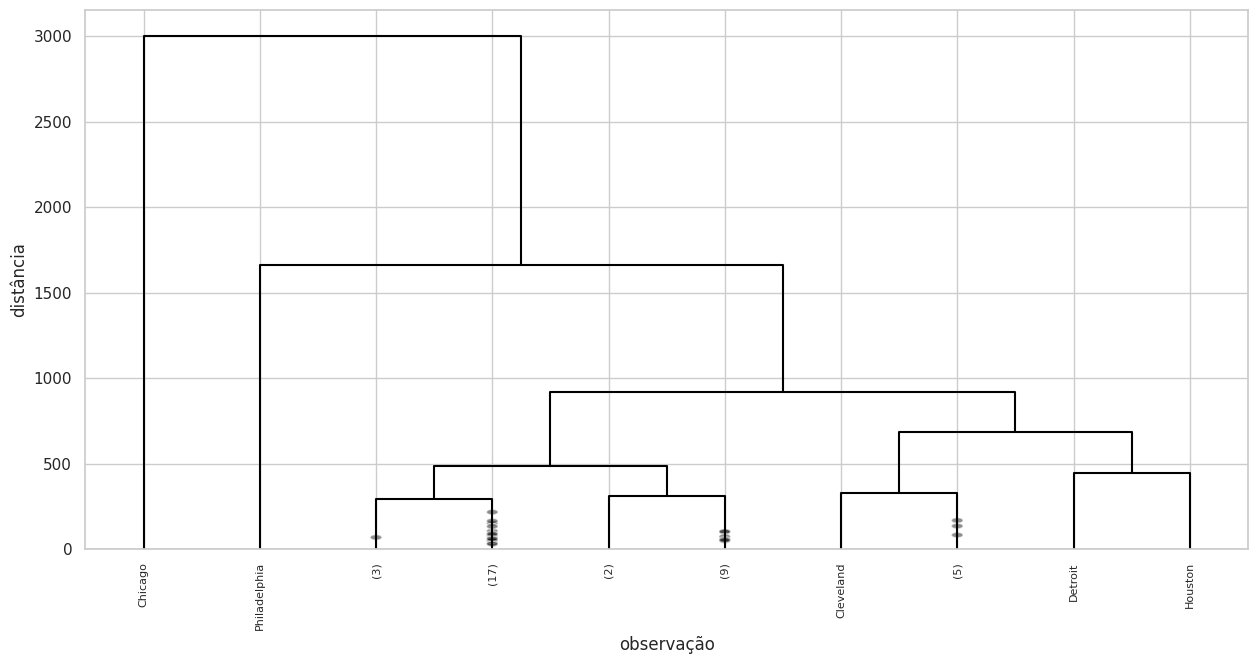

In [130]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Median (não vimos na teoria):

In [131]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [132]:
Z = linkage(X, method='median')

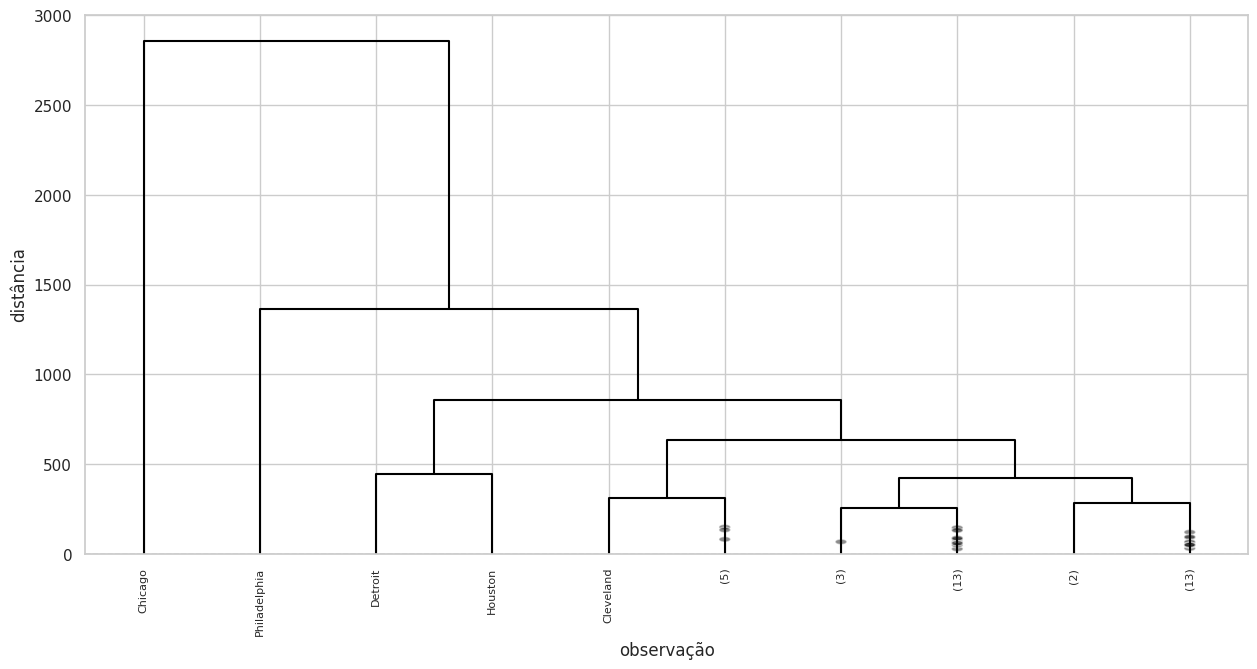

In [133]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Após a observação dos dendrogamas, definir qual vai ser o número de grupos ($k$) a ser utilizado no método das k-médias.

### K-médias

Como é preciso decidir o número de grupos antes de aplicar o método das *k*-médias, usaremos como critério o número de grupos definido a partir da observação do dendrograma. Mas outro método que pode auxiliar é o gráfico k x SQDG:

Gráfico k x SQDG

Auxilia a decidir em quantos grupos dividir os dados usando o método das $k$-médias. Procurar pelo 'cotovelo' (ponto a partir do qual a queda da SQDG é menor).

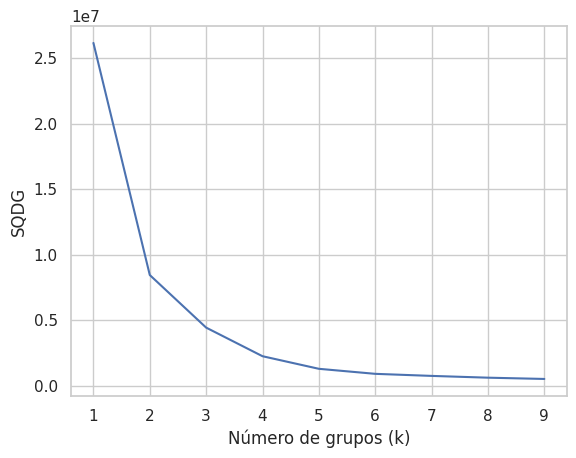

In [134]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(X)
    dados['grupo'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [135]:
# número de grupos sugerido pelo dendrograma
k = 3

In [136]:
# kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto').fit(X)
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(X)

In [137]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos
# com o método das k-médias
resultado['grupo'] = kmeans.labels_

In [138]:
# contagens
resultado.grupo.value_counts()

,count
grupo,
1,31
0,9
2,1


In [139]:
# incluir no dataframe de dados as informações sobre a qual grupo cada pessoa pertence
dados['grupo'] = kmeans.labels_

In [140]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,SO2,temp,manu,popul,wind,precip,predays
grupo,,,,,,,
0,37.33,54.38,865.89,1031.00,10.42,35.80,117.33
1,25.35,56.33,253.23,396.94,9.13,37.12,112.65
2,110.00,50.60,3344.00,3369.00,10.40,34.44,122.00


In [141]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,SO2,temp,manu,popul,wind,precip,predays
grupo,,,,,,,
0,35.00,54.60,721.00,844.00,10.60,35.89,115.00
1,23.00,55.20,266.00,448.00,9.00,38.89,115.00
2,110.00,50.60,3344.00,3369.00,10.40,34.44,122.00


Interpretação dos grupos:

- grupo 0:
- grupo 1:
- ...

Identificação das observações em cada grupo

In [142]:
# observações
grupo0 = dados.query('grupo == 0').index
list(grupo0)

['Baltimore',
 'Cleveland',
 'Dallas',
 'Detroit',
 'Houston',
 'Milwaukee',
 'Minneapolis',
 'Philadelphia',
 'St. Louis']

In [143]:
# os outros grupos
grupo1 = dados.query('grupo == 1').index
list(grupo1)

['Albany',
 'Albuquerque',
 'Atlanta',
 'Buffalo',
 'Charleston',
 'Cincinnati',
 'Columbus',
 'Denver',
 'Des Moines',
 'Hartford',
 'Indianapolis',
 'Jacksonville',
 'Kansas City',
 'Little Rock',
 'Louisville',
 'Memphis',
 'Miami',
 'Nashville',
 'New Orleans',
 'Norfolk',
 'Omaha',
 'Phoenix',
 'Pittsburgh',
 'Providence',
 'Richmond',
 'Salt Lake City',
 'San Francisco',
 'Seattle',
 'Washington',
 'Wichita',
 'Wilmington']

In [144]:
# os outros grupos
# grupo2 = dados.query('grupo == 2').index
# list(grupo2)

In [145]:
resultado['obs'] = resultado.index

In [146]:
# diagrama de dispersão dos CPs usando altair

g = alt.Chart(resultado, height=350, width=500).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado.cp1.min(), resultado.cp1.max()]), axis=alt.Axis(title='CP1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado.cp2.min(), resultado.cp2.max()]), axis=alt.Axis(title='CP2')),
    text='obs',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(pd.DataFrame({'zero': [0]})).mark_rule(color='gray').encode(
    x='zero:Q'
)
# eixo y = 0
bar_y = alt.Chart(pd.DataFrame({'zero': [0]})).mark_rule(color='gray').encode(
    y='zero:Q'
)
g + bar_x + bar_y

alt.LayerChart(...)

<ipython-input-147-014f29da685f>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (xx[i], yy[i]), ha='center', va='center', color=cm.tab10(groups[i]))


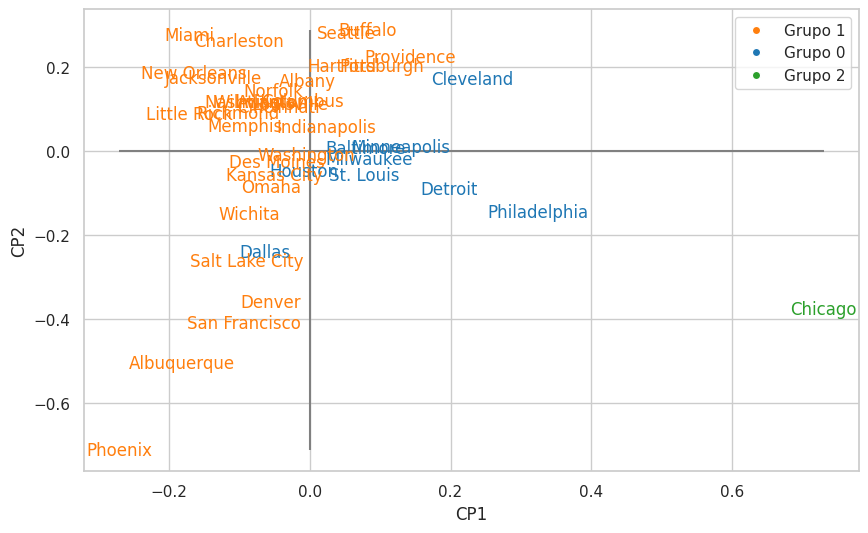

In [147]:
# usando matplotlib

fig, ax = plt.subplots(figsize=(10, 6))
# escores dos dois primeiros CPs
xs = resultado.iloc[:, 0]
ys = resultado.iloc[:, 1]
# padronizar os valores dos CPs
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())
xx = xs * scalex
yy = ys * scaley
# pegar as informações de grupos
groups = resultado['grupo']
# diagrama de dispersão dos escores
ax.scatter(xx, yy, s=0)
# nomes dos eixos
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
# colocar o índice da observação em cada ponto e com cores diferentes para os grupos
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]), ha='center', va='center', color=cm.tab10(groups[i]))

plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray')
# criar legenda
unique_groups = resultado['grupo'].unique()
legend_labels = [f'Grupo {group}' for group in unique_groups]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cm.tab10(group)) for group in unique_groups]
ax.legend(legend_handles, legend_labels)

plt.show()

# Dados de MG

Variáveis:

* rdpc: renda per capita média
* renocup: renda média dos ocupados
* pib_pc: PIB per capita
* fam_pbf: número de famílias que receberam benefício do bolsa família
* tx_emp_form: taxa de emprego no setor formal
* rend_pc_form: rendimento per capita no setor formal
* pop_total: número total de habitantes

In [148]:
# carregando o arquivo a partir de um endereço na internet
dados = pd.read_csv('https://patriciasiqueira.github.io/arquivos/imrs.csv', index_col='mun')
# apenas a mesorregião de Sul de Minas
dados = dados.query("nome_meso == 'Sul/Sudoeste de Minas'")
# selecionar apenas variáveis de interesse
dados = dados.loc[:, ['rdpc', 'renocup', 'pib_pc', 'fam_pbf', 'tx_emp_form', 'rend_pc_form', 'pop_total']]
# taxa de famílias com BF
dados['tx_pbf'] = dados.fam_pbf / dados.pop_total * 100
# selecionar apenas variáveis de interesse - incluindo taxa de famílias atendidas pelo bolsa família
dados = dados.loc[:, ['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf', 'pop_total']]
# fazendo cópia dos dados
X = dados.copy()

In [149]:
# selecionar apenas variáveis de interesse
# dados = dados.loc[:, ['rdpc', 'renocup', 'tx_emp_form', 'rend_pc_form', 'tx_PBF']]

**Desconsiderar algumas observações**

Se houver interesse, algumas observações podem ser retiradas do conjunto de dados. Na célula abaixo retirei os quatro municípios que apresentaram valores muito diferentes dos demais. Bastaria executar todas as células abaixo (começando com ACP) com esse novo conjunto de dados para ver como ficariam as divisões.

É importante notar que a retirada de *outliers* não é o procedimento preferido, já que essas observações são também parte do conjunto de dados. Quando algumas observações são retiradas pode ser que outras apareçam como *outliers* depois.

In [150]:
# retirando BH, Nova Lima, Confins e Jeceaba

# dados = dados.query('mun != ["Belo Horizonte", "Nova Lima", "Confins", "Jeceaba"]')
# dados.shape

### ACP usando a matriz de correlações - para possibilitar a construção de gráficos

In [151]:
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R
# armazenar resultados dos componentes principais para gerar o diagrama de dispersão dos grupos
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [152]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.41,  0.41,  0.32,  0.4 ,  0.41, -0.33,  0.34],
       [-0.39, -0.35,  0.62,  0.2 ,  0.39,  0.02, -0.38],
       [-0.11, -0.01, -0.09,  0.29,  0.23,  0.82,  0.41],
       [-0.37, -0.49, -0.31,  0.22,  0.09, -0.45,  0.52],
       [ 0.05,  0.06, -0.53,  0.64,  0.1 , -0.04, -0.54],
       [ 0.09, -0.03, -0.35, -0.5 ,  0.78, -0.01, -0.11],
       [ 0.72, -0.68,  0.07,  0.05, -0.04,  0.1 , -0.02]])

In [153]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([4.45, 1.  , 0.61, 0.49, 0.35, 0.08, 0.06])

In [154]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([63.16, 77.34, 86.03, 93.01, 98.03, 99.2 , 99.99])

In [155]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.41  0.41  0.32  0.4   0.41 -0.33  0.34]
 [-0.39 -0.35  0.62  0.2   0.39  0.02 -0.38]
 [-0.11 -0.01 -0.09  0.29  0.23  0.82  0.41]]


Biplot:

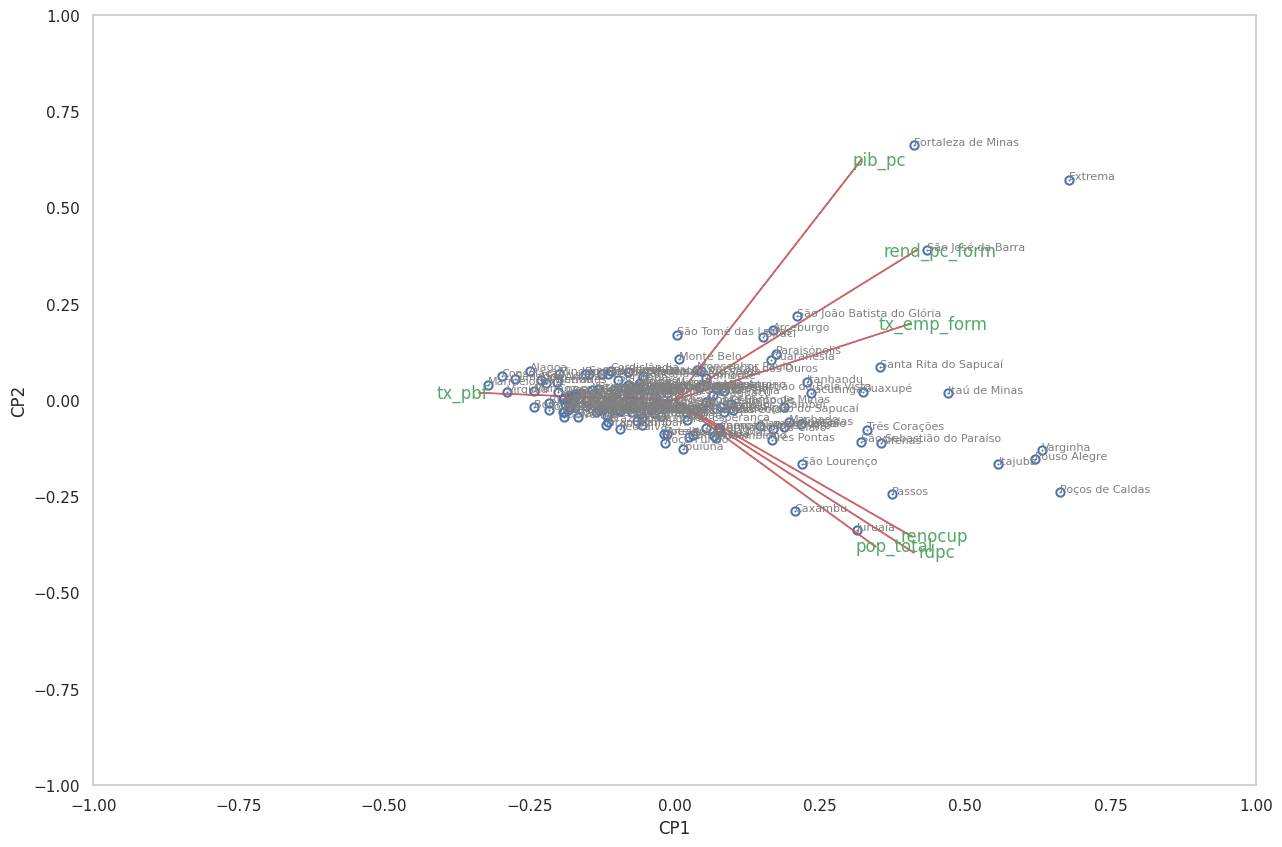

In [156]:
biplot_names(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))

<ipython-input-157-5e934e03d9f2>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (xx[i], yy[i]))


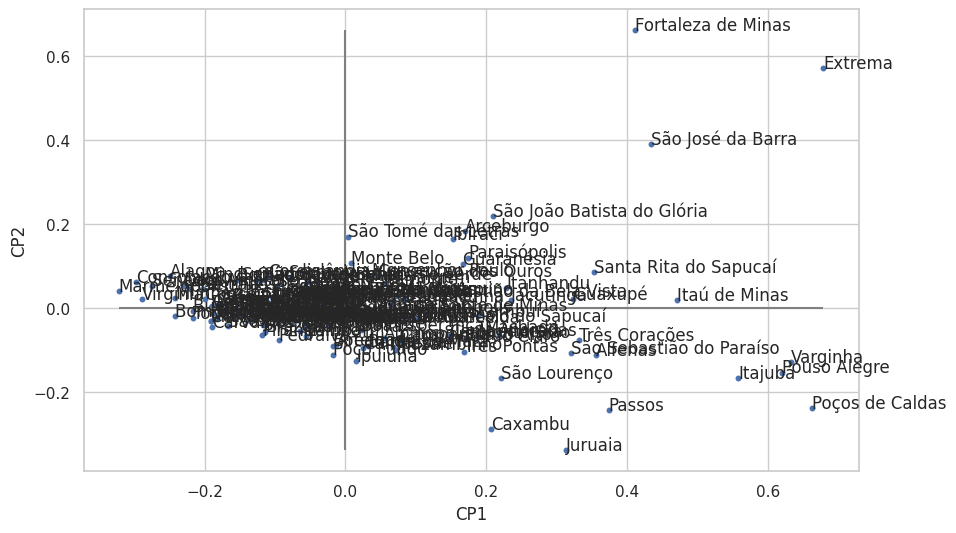

In [157]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
ax.scatter(xx, yy,s=5, linewidths=2)
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');

### Análise de agrupamento hierárquico

Vizinho mais próximo:

In [158]:
# definir a distância de corte para todos os dendrogramas
max_d = 0

In [159]:
Z = linkage(X, method='single')
# method='single' (vizinho + próximo), 'complete' (vizinho + distante), 'average' (distância média), 'weighted '(also called WPGMA)
# 'centroid', 'median', 'ward'

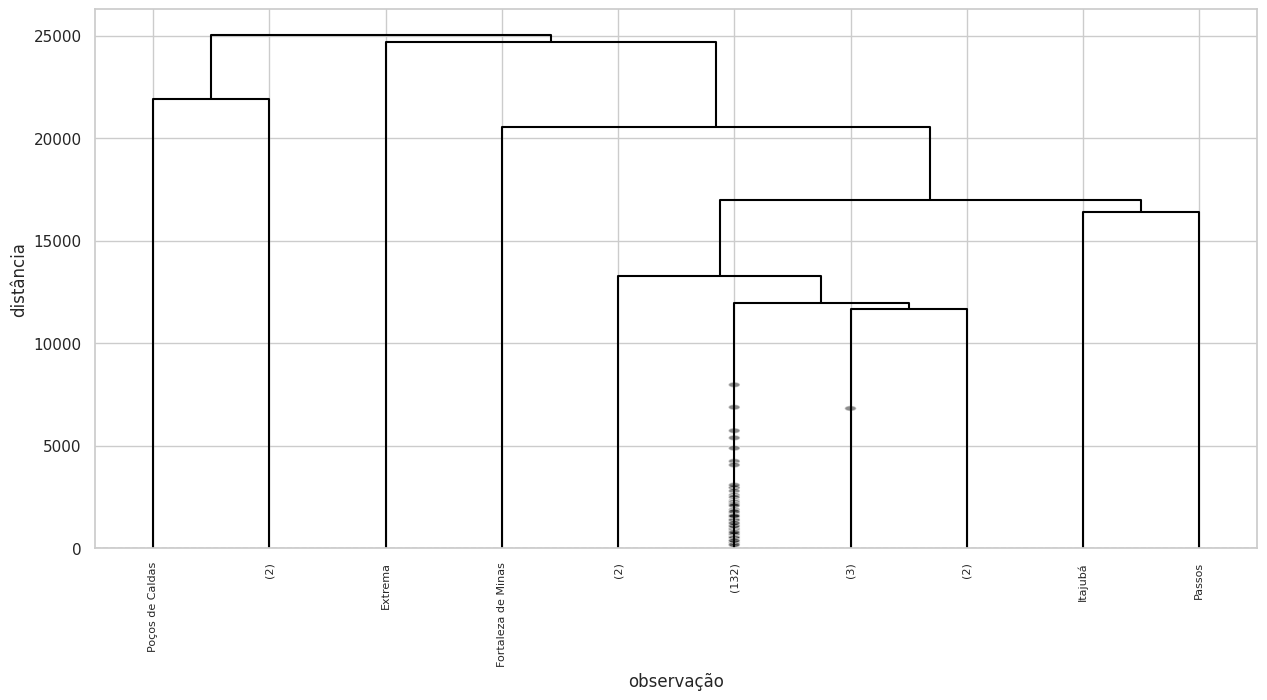

In [160]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Vizinho mais distante:

In [161]:
Z = linkage(X, method='complete')

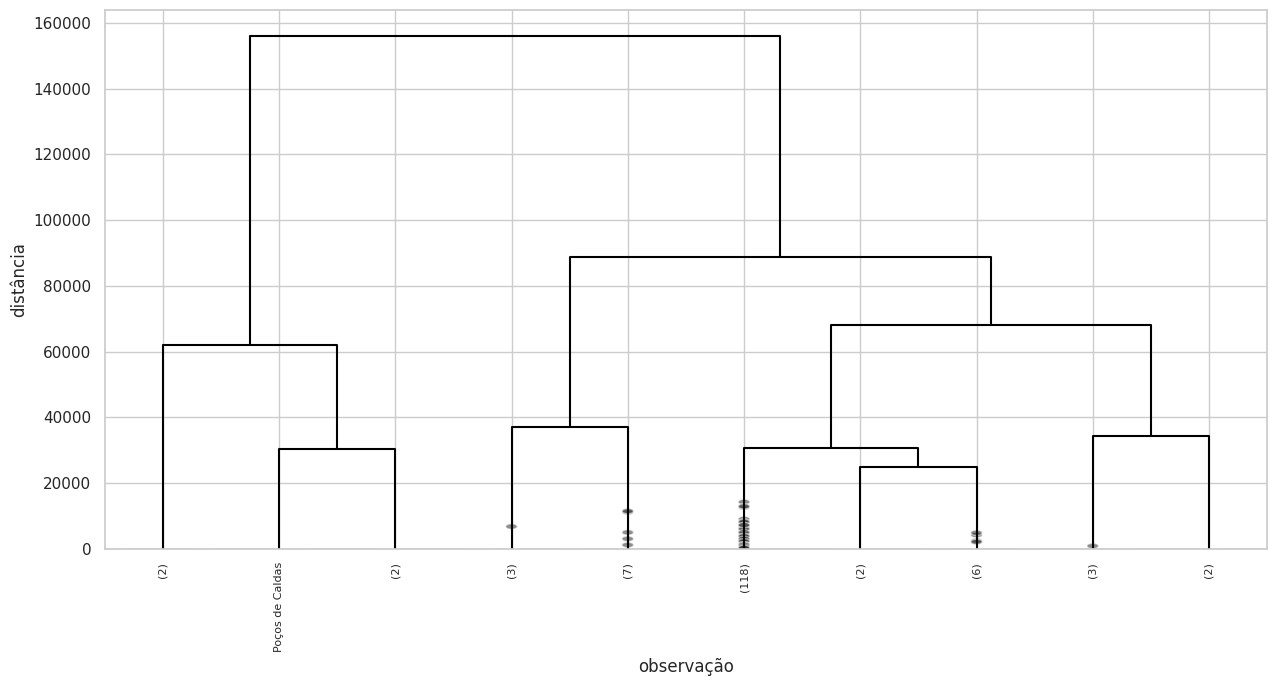

In [162]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Distância média:

In [163]:
Z = linkage(X, method='average')
# 'single', 'complete', 'average', 'centroid', 'ward'

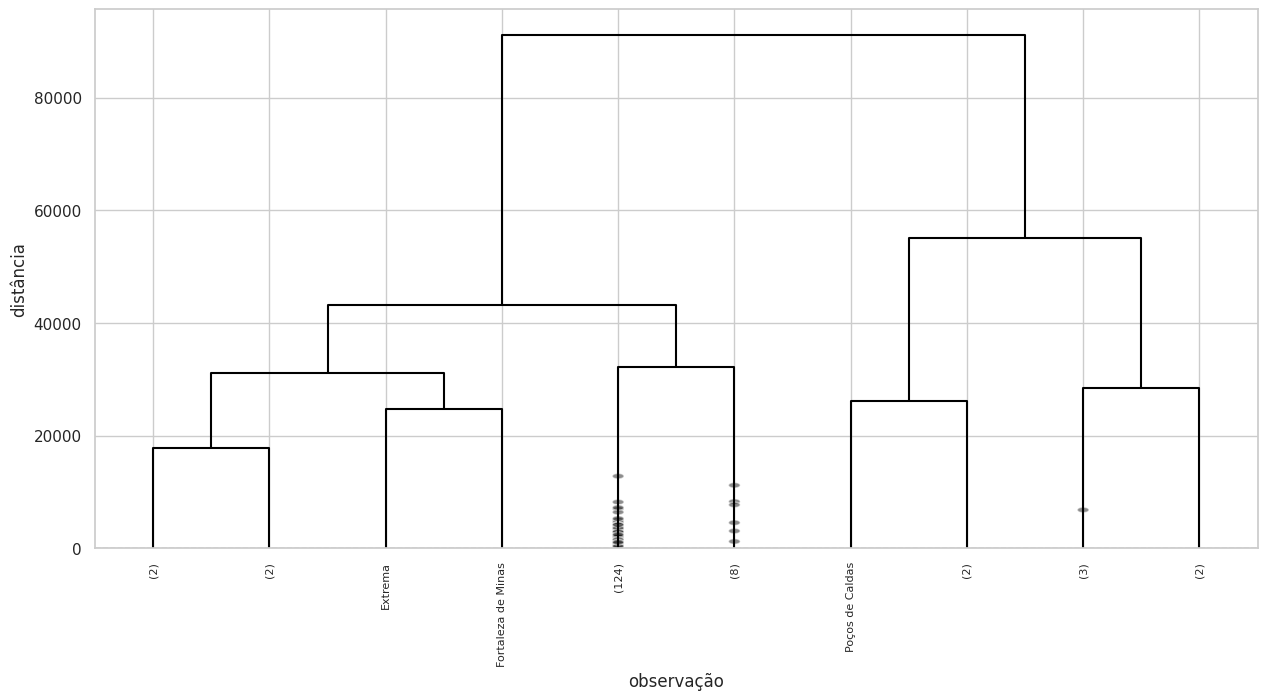

In [164]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Centroide:

In [165]:
Z = linkage(X, method='centroid')

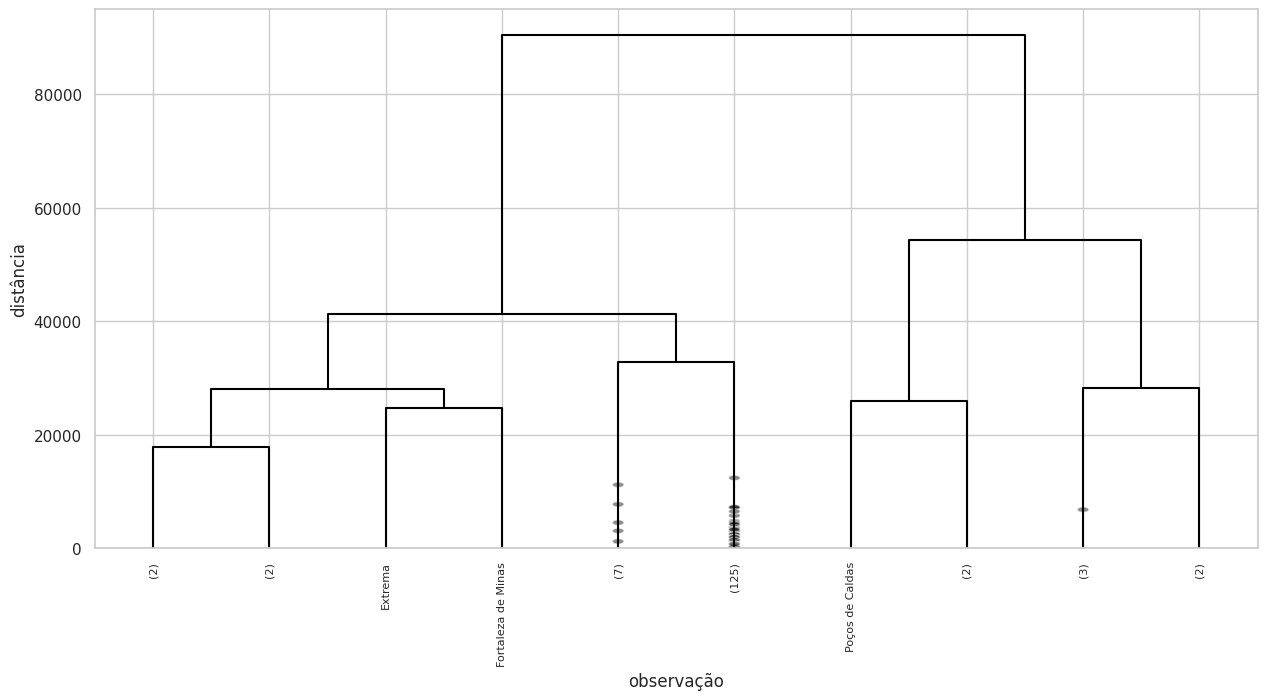

In [166]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Ward:

In [167]:
Z = linkage(X, method='ward')
# 'single', 'complete', 'average', 'centroid', 'ward'

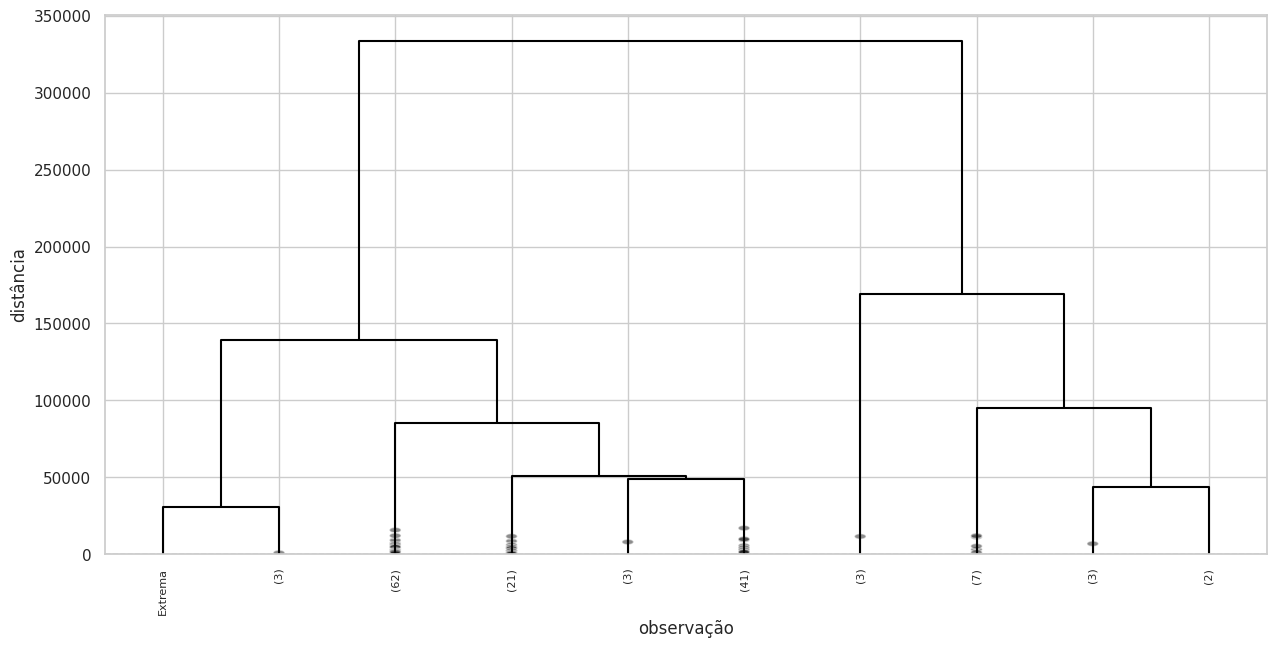

In [168]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Weighted (não vimos na teoria):

In [169]:
Z = linkage(X, method='weighted')
# method='single' (vizinho + próximo), 'complete' (vizinho + distante), 'average' (distância média), 'weighted '(also called WPGMA)
# 'centroid', 'median', 'ward'

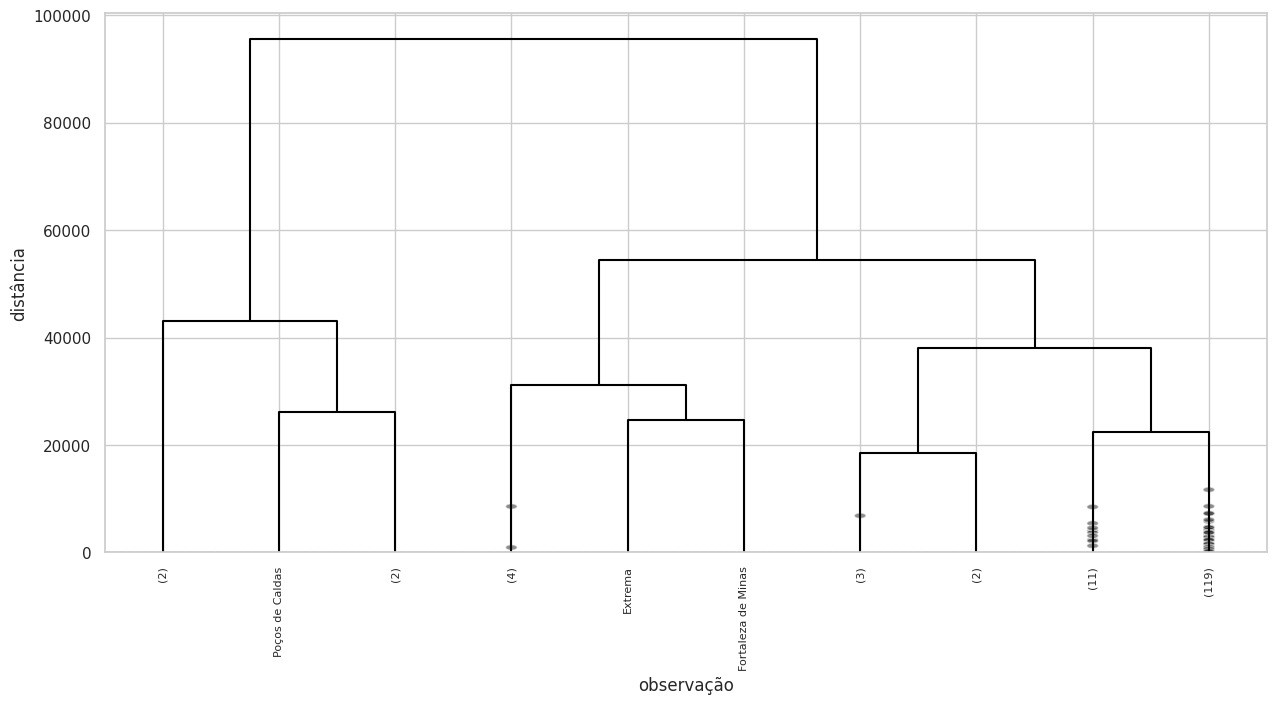

In [170]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Median (não vimos na teoria):

In [171]:
Z = linkage(X, method='median')

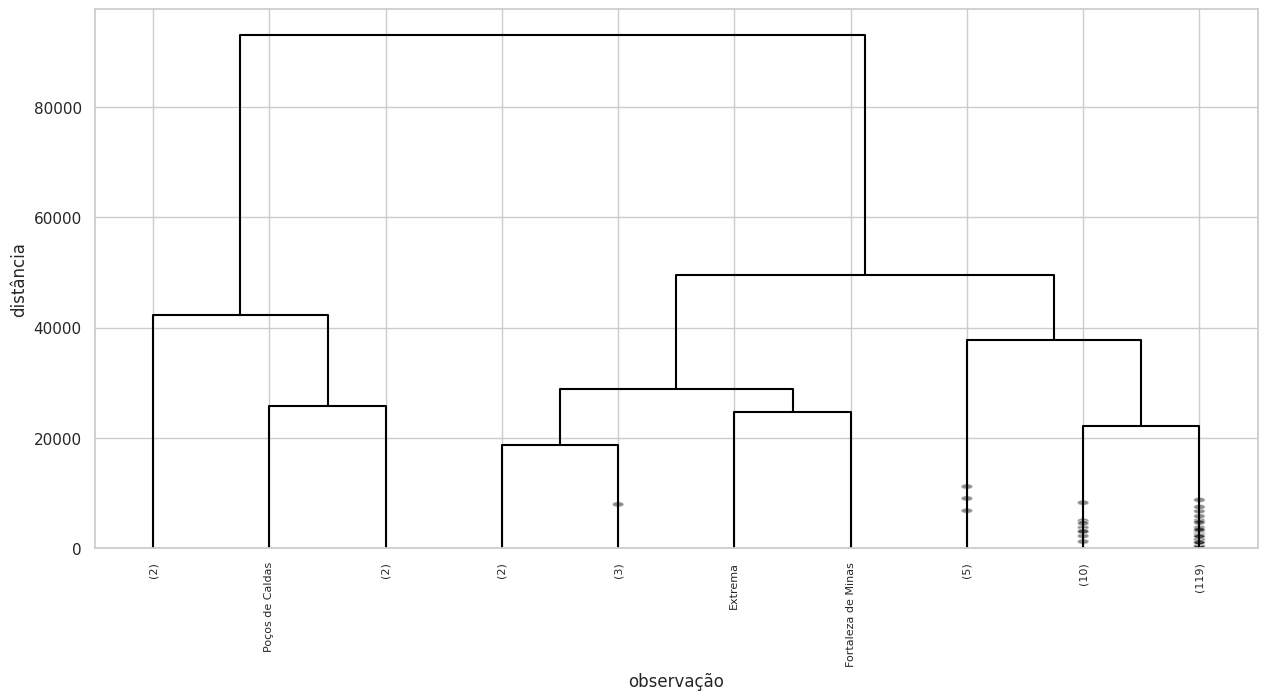

In [172]:
# dendrograma com mais opções
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=10,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('observação')
plt.ylabel('distância');

Após a observação dos dendrogamas, definir qual vai ser o número de grupos ($k$) a ser utilizado no método das k-médias.

### K-médias

Como é preciso decidir o número de grupos antes de aplicar o método das *k*-médias, usaremos como critério o número de grupos definido a partir da observação do dendrograma. Mas outro método que pode auxiliar é o gráfico k x SQDG:

Gráfico k x SQDG

Auxilia a decidir em quantos grupos dividir os dados usando o método das $k$-médias. Procurar pelo 'cotovelo' (ponto a partir do qual a queda da SQDG é menor).

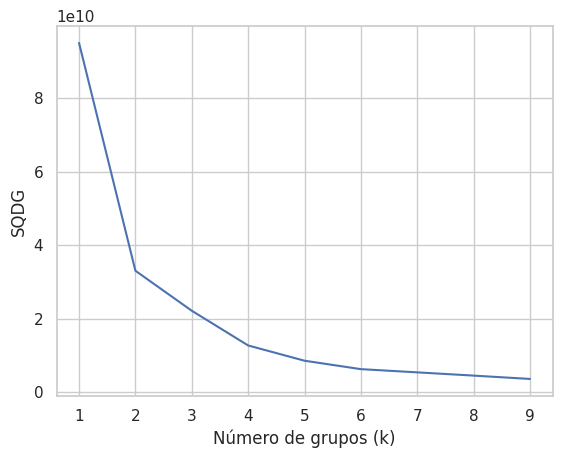

In [173]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(X)
    dados['grupo'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [187]:
# número de grupos sugerido pelo dendrograma
k = 4

In [188]:
# kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto').fit(X)
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(X)

In [189]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos
# com o método das k-médias
resultado['grupo'] = kmeans.labels_

In [190]:
# contagens
resultado.grupo.value_counts()

,count
grupo,
0,125
2,11
3,5
1,5


In [191]:
# incluir no dataframe de dados as informações sobre a qual grupo cada pessoa pertence
dados['grupo'] = kmeans.labels_

In [192]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,rdpc,renocup,pib_pc,tx_emp_form,rend_pc_form,tx_pbf,pop_total
grupo,,,,,,,
0,555.98,831.96,10999.66,21.25,127.26,6.43,9896.61
1,897.59,1352.82,22347.05,40.70,356.88,2.60,120638.80
2,727.10,1089.40,16966.78,33.34,236.90,4.79,49126.45
3,661.55,1048.70,56789.41,34.30,399.56,3.38,11701.40


In [193]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,rdpc,renocup,pib_pc,tx_emp_form,rend_pc_form,tx_pbf,pop_total
grupo,,,,,,,
0,539.92,813.53,10345.80,19.40,113.90,6.27,8185.00
1,904.57,1364.19,23302.77,41.70,382.96,1.97,123120.00
2,746.70,1085.02,17007.36,33.50,235.46,4.43,41664.00
3,676.07,1081.48,52065.19,28.30,521.53,3.47,6890.00


Interpretação dos grupos:

- grupo 0:
- grupo 1:
- ...

Identificação das observações em cada grupo

In [194]:
# observações
# grupo0 = dados.query('grupo == 0').index
# list(grupo0)

In [195]:
# os outros grupos
# grupo1 = dados.query('grupo == 1').index
# list(grupo1)

In [196]:
# os outros grupos
# grupo2 = dados.query('grupo == 2').index
# list(grupo2)

In [197]:
resultado['obs'] = resultado.index

In [198]:
# diagrama de dispersão dos CPs usando altair

g = alt.Chart(resultado, height=350, width=500).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado.cp1.min(), resultado.cp1.max()]), axis=alt.Axis(title='CP1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado.cp2.min(), resultado.cp2.max()]), axis=alt.Axis(title='CP2')),
    text='obs',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(pd.DataFrame({'zero': [0]})).mark_rule(color='gray').encode(
    x='zero:Q'
)
# eixo y = 0
bar_y = alt.Chart(pd.DataFrame({'zero': [0]})).mark_rule(color='gray').encode(
    y='zero:Q'
)
g + bar_x + bar_y

alt.LayerChart(...)

<ipython-input-199-014f29da685f>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (xx[i], yy[i]), ha='center', va='center', color=cm.tab10(groups[i]))


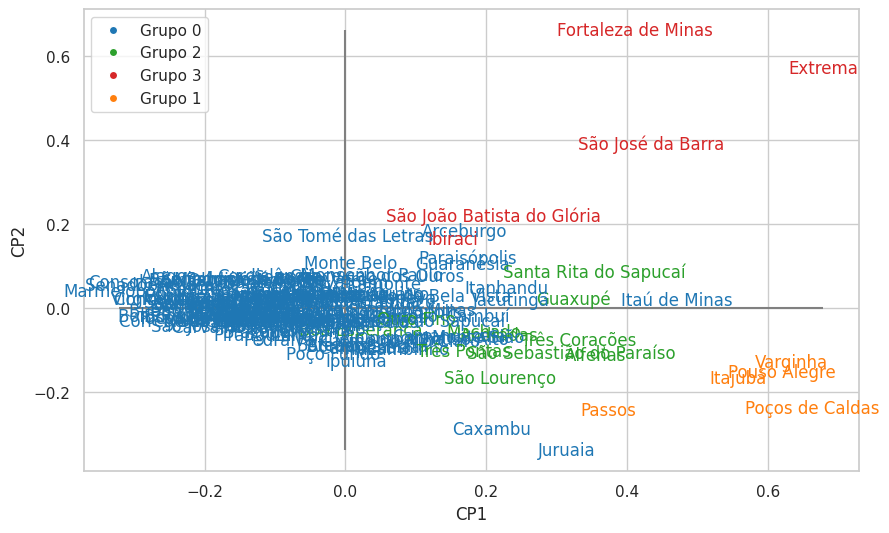

In [199]:
# usando matplotlib

fig, ax = plt.subplots(figsize=(10, 6))
# escores dos dois primeiros CPs
xs = resultado.iloc[:, 0]
ys = resultado.iloc[:, 1]
# padronizar os valores dos CPs
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())
xx = xs * scalex
yy = ys * scaley
# pegar as informações de grupos
groups = resultado['grupo']
# diagrama de dispersão dos escores
ax.scatter(xx, yy, s=0)
# nomes dos eixos
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
# colocar o índice da observação em cada ponto e com cores diferentes para os grupos
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]), ha='center', va='center', color=cm.tab10(groups[i]))

plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray')
# criar legenda
unique_groups = resultado['grupo'].unique()
legend_labels = [f'Grupo {group}' for group in unique_groups]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cm.tab10(group)) for group in unique_groups]
ax.legend(legend_handles, legend_labels)

plt.show()